딥러닝 파이토치 교과서
ch7. 5
 p.393~417

# CH 7. 시계열 분석
## 7.5 LSTM 구조



RNN의 단점
- 가중치가 업데이트되는 과정에서 기울기가 1보다 작은 값이 계속 곱해지기 때문에 기울기가 사라지는 기울기 소멸 문제 발생
- 해결하기 위해 LSTM이나 GRU 같은 확장된 RNN 방식 사용하기

### 7.5.1 LSTM 구조

#### [LSTM 순전파]
LSTM : 기울기 소멸 문제 해결 위해 망각 게이트, 입력 게이트, 출력 게이트라는 새로운 요소를 은닉층의 각 뉴런에 추가함

<망각 게이트>

망각 게이트 : 과거 정보를 어느 정도 기억할지 결정함

- 과거 정보와 현재 데이터를 입력 받아 시그모이드를 취한 후, 그 값을 과거 정보에 곱해줌
- 시그모이드 출력이 0이면 과거 정보는 버리고, 1이면 과거 정보는 보존

- 입력값 : 0과 1 사이의 출력 값을 가지는 h(t-1)과 x(t)
    - h(t-1) : 이전 은닉층에서 입력되는 값
    - x(t) : 새로운 입력 값
- 망각 게이트에 대한 수식
    - 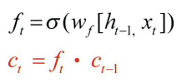
    - 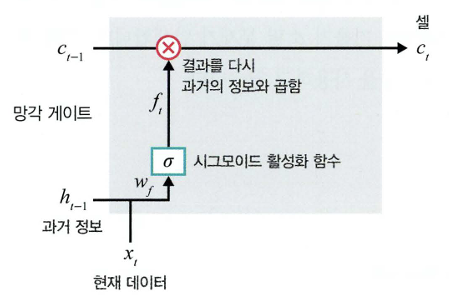

<입력 게이트>

입력 게이트 (input gate) : 현재 정보를 기억하기 위해 만들어짐
- 과거 정보와 현재 데이터를 입력받아 시그모이드와 하이퍼볼릭 탄젠트함수를 기반으로 현재 정보에 대한 보존량을 결정
- 계산한 값이 1 : 입력 x(t)가 들어올 수 있도록 허용
- 계산한 값이 0 : 차단
- 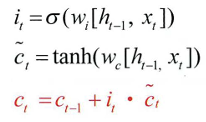
- 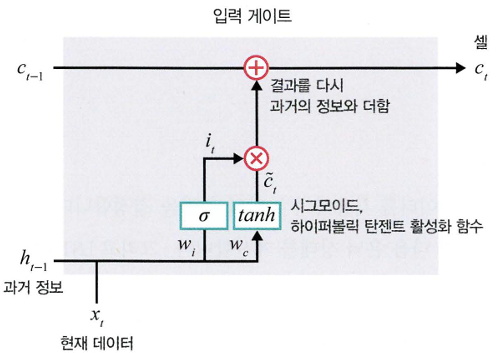

<셀>

메모리 셀 : 각 단계에 대한 은닉 노드 (hidden node)
- 총합을 사용하여 셀 값을 반영 -> 기울기 소멸 문제가 해결됨

- 셀을 업데이트 하는 방법 : 망각 게이트와 입력 게이트의 이전 단계 셀 정보를 계산하여 현재 단계의 셀 상태를 업데이트
- 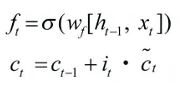

- 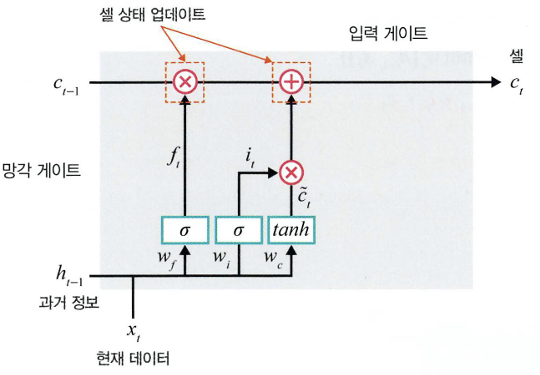

<출력 게이트>

출력 게이트 : 과거 정보와 현재 데이터를 사용하여 뉴런의 출력을 결정함
- 이전 은닉 상태와 t번째 입력을 고려해서 다음 은닉 상태를 계산
- LSTM에서는 이 은닉 상태가 그 시점에서의 출력이 됨
- 계산한 값이 1 : 의미 있는 결과로 최종 출력
- 계산한 값이 0 : 해당 연산 출력을 하지 않음
- 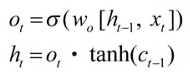

- 출력 게이트
- 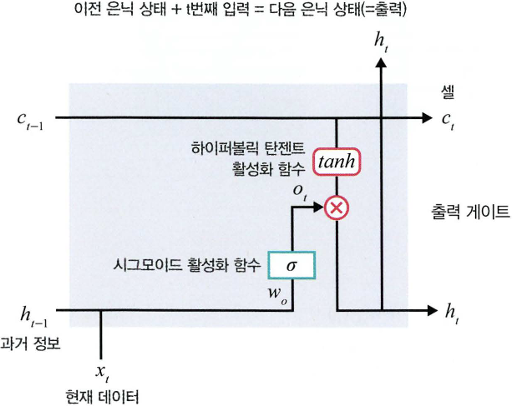
- LSTM 전체 게이트
- 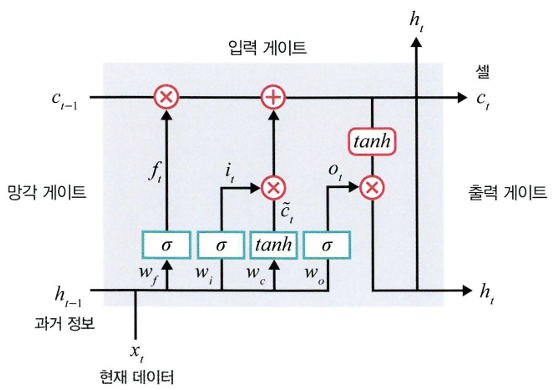

### [LSTM 역전파]
LSTM : 셀을 통해서 역전파를 수행하기 때문에 '중단 없는 기울기'라고도 함
- 최종 오차는 모든 노드에 전파되는데, 이때 셀을 통해서 중단 없이 전파됨
- 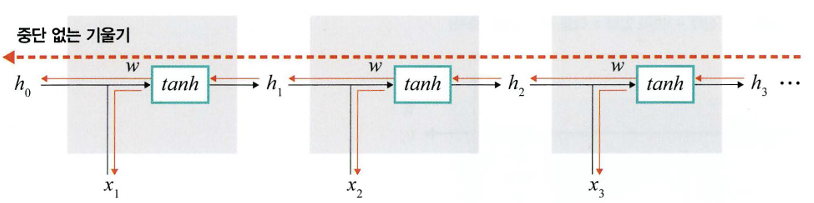

- 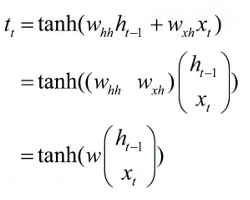

- 셀 단위로 오차가 전파된다고 해서 입력 방향으로 오차가 전파되지 않는 것은 아님
- 셀 내부적으로는 오차가 입력으로 전파됨
- 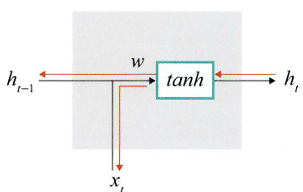

### 7.5.2 LSTM 셀 구현
LSTM을 파이토치로 구현하기

라이브러리 호출

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

데이터 전처리 : 평균과 표준편차에 맞게 데이터를 정규화

In [ ]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,)) # 평균을 0.5, 표준편차를 1.0으로 데이터 정규화
])

MNIST 데이터셋 내려받기

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(root='./data', train=True, transform=mnist_transform, download=True)
valid_dataset = MNIST(root='./data', train=False, transform=mnist_transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=mnist_transform, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 48.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.82MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.85MB/s]


데이터셋을 메모리로 가져오기

In [ ]:
batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

배치 크기 및 에포크 등 변수에 대한 값을 지정

In [ ]:
batch_size = 100
n_iters = 6000

iterations_per_epoch = len(train_dataset) / batch_size
num_epochs = int(n_iters / iterations_per_epoch)

LSTM 셀에 대한 네트워크 구축 : 모델의 전반적인 네트워크가 아닌 LSTM 셀에 집중한 네트워크

In [ ]:
class LSTMCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias) # 1
        self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias) # 1
        self.reset_parameters()

    def reset_parameters(self) : # 모델의 파라미터 초기화
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() :
            w.data.uniform_(-std, std) # 2

    def forward(self, x, hidden):
        hx, cx = hidden
        x = x.view(-1, x.size(1))

        gates = self.x2h(x) + self.h2h(hx) # 1
        gates = gates.squeeze() # 3
        ingate, forgetgate, cellgate, outgate = gates.chunk(4,1) # 1

        ingate = F.sigmoid(ingate) # 입력 게이트에 시그모이드 활성화 함수 적용
        forgetgate = F.sigmoid(forgetgate) # 망각 게이트에 시그모이드 활성화 함수 적용
        cellgate = F.tanh(cellgate) # 셀 게이트에 탄젠트 활성화 함수 적용
        outgate = F.sigmoid(outgate) # 출력 게이트에 시그모이드 활성화 함수 적용

        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate) # 4
        hy = torch.mul(outgate, F.tanh(cy)) # 4
        return(hy, cy)

1. 4 * hidden_size
- 은닉층의 뉴런/유닛에 4를 곱하기
- gates.chunk(4,1)에 의해 네 개로 쪼개져서 각각 망각,입력, 셀, 출력 게이트를 의미하는 변수가 저장됨
- gates가 네 개로 쪼개지는 상황 -> 4를 곱하기
- 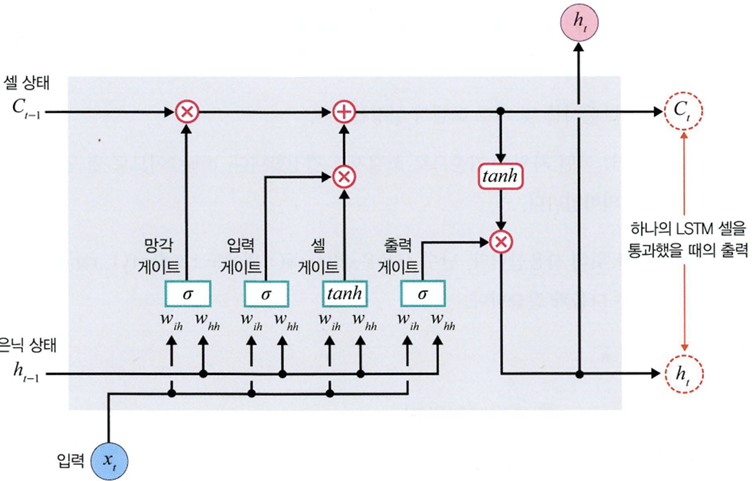

2. uniform() : 난수 사용

In [ ]:
from random import *

ri = randint(1,10) # 1부터 10 사이의 임의의 정수
print(ri)

rd = random() # 0부터 1 사이의 임의의 실수 (float)
print(rd)

ui = uniform(1,10) # 1부터 10 사이를 2씩 건너뛴 임의의 정수
print(ui)

rr = randrange(1,10,2) # 1부터 10사이를 2씩 건너뛴 임의의 정수
print(rr)

7
0.21226542413308847
1.9590535643176858
9


3. torch.squeeze() : 텐서의 차원을 줄이고자 할 때 사용

In [ ]:
import torch

x = torch.FloatTensor([[1], [2]])
print(x)
print(x.shape)
print('--squeeze 적용--')
print(x.squeeze()) # squeeze()가 적용되어 1차원으로 축소
print(x.squeeze().shape)

tensor([[1.],
        [2.]])
torch.Size([2, 1])
--squeeze 적용--
tensor([1., 2.])
torch.Size([2])


4. 하나의 LSTM 셀을 통과하면 셀 상태와 은닉 상태가 출력으로 주어짐
- 셀 상태는 입력, 망각, 셀 게이트에 의해 계산됨
- 은닉 상태는 출력 게이트에 의해 계산됨

In [ ]:
import torch
x = torch.FloatTensor(([1], [2]))
print(x)
print('--mul 적용--')
torch.mul(x,3) # x라는 텐서의 원소에 3을 곱하기

tensor([[1.],
        [2.]])
--mul 적용--


tensor([[3.],
        [6.]])

LSTM 셀의 전반적인 네트워크

In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module) :
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias = True) :
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim # 은닉층의 뉴런/유닛 개수

        self.layer_dim = layer_dim
        self.lstm = nn.LSTMCell(input_dim, hidden_dim, layer_dim) # 1
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x) :
        if torch.cuda.is_available(): # GPU 사용 유무 확인
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
            # (은닉층의 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 은닉 상태를 0으로 초기화
        else :
            h0 = Variable(torch.zeors(self.layer_dim, x.size(0), self.hidden_dim))

        if torch.cuda.is_available() : # GPU 사용 유무 확인
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
            # (은닉층의 개수, 배치 크기, 은닉층의 뉴런 개수) 형태를 갖는 은닉 상태를 0으로 초기화
        else :
            c0 = Variable(torch.zeors(self.layer_dim, x.size(0), self.hidden_dim))

        outs = []
        cn = c0[0, :, :] # (은닉층의 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 셀 상태에 대한 텐서
        hn = c0[0, :, :] # (은닉층의 개수, 배치 크기, 은닉층의 뉴런 개수) 크기를 갖는 은닉 상태에 대한 텐서

        for seq in range(x.size(1)): # LSTM 셀 계층을 반복하여 쌓아 올림
            hn, cn = self.lstm(x[:, seq, :], (hn, cn))
            # 은닉 상태(hn)와 셀 상태를 LSTMCell에 적용한 결과를 또다시 hn, cn에 저장

        out = outs[-1].squeeze()
        out = self.fc(out)
        return out

옵티마이저 손실 함수를 지정

In [ ]:
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available(): # GPU 사용 유무 확인
    model.cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

훈련 데이터셋을 이용하여 모델을 학습시키고, 검증 데이터셋을 이용하여 모델 성능을 확인하기

In [ ]:
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs) :
    for i , (images, labels) in enumerate(train_loader) : # 훈련 데이터셋을 이용한 모델 학습
        if torch.cuda.is_available() : # GPU 사용 유무 확인
            images = Variable(images.view(-1, seq_dim, input_dim).cuda()) # 1
            labels = Variable(labels.cuda())
        else : # GPU를 사용하지 않기 때문에 else 구문이 실행
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels) # 손실 함수를 이용하여 오차 계산

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step() # 파라미터 업데이트
        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0 : # 정확도 계산
            correct = 0
            total = 0
            for images, labels in valid_loader : # 검증 데이터셋을 이용한 모델 성능 검증

                if torch.cuda.is_available() :
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else :
                    images = Variable(images.view(-1, seq_dim, input_dim))

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            # 모델을 통과한 결과의 최댓값으로부터 예측 결과 가져오기

            total += labels.size(0) # 총 레이블 수
            if torch.cuda.is_available() :
                correct += (predicted.cpu() == labels.cpu()).sum()
            else :
                correct += (predicted == labels).sum()

        accuracy = 100 * correct/total
        print('Iteration: {}. Loss : {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

NameError: name 'num_epochs' is not defined

=> 정확도가 97%로 상당히 높은 편

테스트 데이터셋을 이용하여 모델 에측 성능 살펴보기

In [ ]:
def evaluate(model, val_iter):
    corrects, total, total_loss = 0,0,0
    model.eval()
    for images, labels in val_iter :
        if torch.cuda.is_available() : # GPU 사용 유무 확인
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else :
            images = Variable(images.view(-1, seq_dim, input_dim).to(device))

        logit = model(images).to(device)
        loss = F.cross_entropy(logit, labels, reduction='sum')
        # reduction='sum' 을 지정했기 때문에 모든 오차를 더하기
        _, predicted = torch.max(logit.data, 1)
        # logit.data 텐서에서 최댓값의 인덱스를 반환
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy


모델 예측 성능 확인

In [ ]:
test_loss, test_acc = evaluate(model, test_loader)
print('Test Loss : %5.2f | Test Accuracy : %5.2f' % (test_loss, test_acc))

### 7.5.3 LSTM 계층 구현

스타벅스 주가 데이터셋 사용

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/2025-1/2025-1 ESAA OB/과제/data/SBUX.csv')
print(data.dtypes)

날짜 칼럼을 인덱스로 사용
- 이번 예제에서 사용할 데이터들은 숫자라서 임베딩이 필요하지 않음
- 단어들로 구성된 데이터셋은 임베딩 과정을 거쳐야 함

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True) # 'date' 칼럼을 인덱스로 사용

데이터 형식 변경

In [ ]:
data['volume'] = data['volume'].astype(float) # 데이터 형식을 변경할 때는 astype()을 사용

훈련과 레이블 분리

In [ ]:
X = data.iloc[:, :-1] # 마지막 칼럼을 제외한 모든 칼럼을 x로 사용
y = data.iloc[:, 5:6] # 마지막 'Volume' 을 레이블로 사용
print(X)
print(y)

데이터셋에서 데이터 간의 분포 조정

In [ ]:
ms = MinMaxScaler() # 데이터의 모든 값이 0~1 사이에 존재하도록 분산 조정
ss = StandardScaler() # 데이터가 평균 0, 분산 1이 되도록 분산 조정

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :] # 훈련 데이터셋
X_test = X_ss[200:, :] # 테스트 데이터셋

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print('Training Shape' , X_train.shape, y_train.shape)
print('Testing Shape', X_test.shape, y_test.shape)

데이터셋의 형태 및 크기 조정

In [ ]:
X_train_tensors = Variable(torch.Tensor(X_train))
# Variable 로 감싸진 텐서는 .backward()가 호출될 때 자동으로 기울기가 계산
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1])) # 1
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print('Training Shape', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape', X_test_tensors_f.shape, y_test_tensors.shape)

1. torch.reshape : 텐서의 형태를 바꿀 때 사용
- 훈련 데이터셋의 형태를 (200, 5) 를 (200, 1, 5) 로 변경

LSTM 네트워크

In [ ]:
class LSTM(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(LSTM, self).__init()
        self.num_classes = num_classes # 클래스 개수
        self.num_layers = num_layers # LSTM 계층의 개수
        self.input_size = input_size # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
        self.hidden_size = hidden_size # 은닉층의 뉴런 개수
        self.seq_length = seq_length # 시퀀스 길이

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True) # LSTM 계층
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전 연결층
        self.fc = nn.Linear(128, num_classes) # 출력층
        self.relu = nn.ReLU()

    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉 상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 셀 상태를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size) # 완전연결층 적용을 위해 데이터의 형태 조정 (1차원으로 조정)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

변수 값 설정

In [ ]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

모델 학습

In [ ]:
for epoch in range(num_epochs) :
    outputs = model.forward(X_train_tensors_f) # 전방향 학습
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors) # 손실 함수를 이용한 오차 계산 (모델 학습 결과 레이블의 차이 계산)
    loss.backward() # 기울기 계산

    optimizer.step() # 오차 업데이트
    if epoch % 100 ==0 : # 1000을 100으로 나누어 나머지가 0이면 출력
        print('Epoch: %d, loss: %1.5f' % (epoch, loss.item()))

모델 예측 결과를 출력하기 위한 데이터 크기 재구성

In [ ]:
df_x_ss = ss.transform(data.iloc[:, :-1]) # 데이터 정규화 (분포 조정)
df_y_ss = ss.transform(data.iloc[:, -1:]) # 데이터 정규화

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ss = Variable(torch.Tensor(df_y_ss))

df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

모델 예측 결과 출력

In [ ]:
train_predict = model(df_x_ss) # 훈련 데이터셋을 모델에 적용하여 모델 학습
predicted = train_predict.data.numpy() # 모델 학습 결과를 넘파이로 변경
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted) # 모델 학습을 위해 전처리했던 것을 해제
label_y = ms.inverse_transform(label_y)
plt.figure(figsize = (10,6)) # 그래프로 표시
plt.axvline(x=200, c='r', linestyle = '--') # 1

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

1. axvline()

- axvline과 axhline
    - 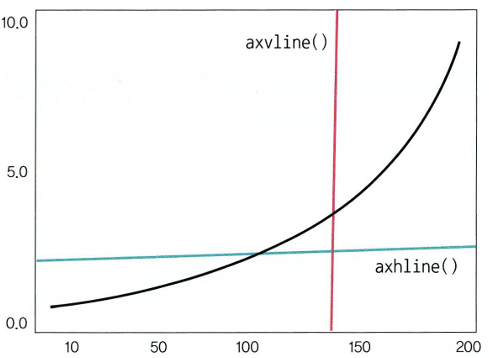

- LSTM 모델 예측 결과
    - 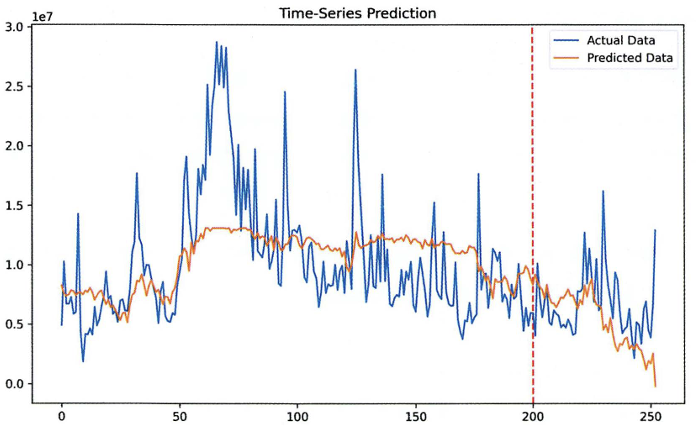

    - 파란색 : 실제 레이블에 대한 출력 결과
    -주황색 : 모델이 예측한 결과